In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Data

In [2]:
def LoadPmg(path):
    with open(path,'rb') as file:
        # the first 4 lines are
        # 1. magic number P5 = binary file
        # 2. comment line
        # 3. width & height = 195* 231 
        # 4. maximum value
        file.readline()
        file.readline()     
        
        line = file.readline().split()
        w = int(line[0])
        h = int(line[1])
        
        file.readline()      
        
        img = np.zeros((h, w))        
        for r in range(h):
            for c in range(w):
                img[r][c] = ord(file.read(1))
                
        return img        

In [3]:
def Resize(img):
    new_img = np.zeros((img_h, img_w)) 
    for r in range(img_h):
        for c in range(img_w):
            val = 0
            for i in range(scalar):
                for j in range(scalar):
                    val+=img[r*scalar +i][c*scalar +j]
            new_img[r][c] = val//(scalar*scalar) 
    new_img = new_img.reshape(-1)
    return new_img            

In [4]:
def LoadData(path):
    imgs = []
    labels = []
    for file in os.listdir(path):
        labels.append(int(file[7:9]))
        img = LoadPmg(os.path.join(path,file))
        img = Resize(img)
        imgs.append(img)
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels 

## PCA
Goal: maximize variance<br>
Solution: <br>
$z = Wx $<br>
$Cov(z) = WSW^T , S = Cov(x)$<br>
W = eigenvectors corresponding to the k largest eigenvalues of S

In [5]:
def PCA(X, kernel = None):
    if kernel  == 'linear':
        X = Linear_K(X,X)
    elif kernel == 'rbf':
        X = RBF_K(X,X)
        
    cov = np.cov(X.T)
    eigenvalue, eigenvector = np.linalg.eigh(cov)
    
    sorted_idx = np.argsort(eigenvalue)[::-1]
    eigenvector = eigenvector[:,sorted_idx]    
    W = eigenvector[:,:k_eigen]
    # whitening
    for i in range(k_eigen):
        W[:, i] /= np.linalg.norm(W[:, i])
        
    return W, X

## Kernel PCA

In [139]:
def Linear_K(X1,X2):
    return X1 @ X2.T

In [140]:
def RBF_K(X1,X2):
    square_X1 = np.sum(X1 ** 2, axis=1).reshape(-1, 1)
    square_X2 = np.sum(X2 ** 2, axis=1)
    d = square_X1 - 2 * X1 @ X2.T + square_X2
    k = np.exp(-gamma* d)
    return k

## LDA
$class: k = 15$<br>
$within-class\ scatter: S_W = \sum_{j=1}^kS_j,\ S_j = \sum_{i \in C_j}(x_i - m_j)(x_i - m_j)^T,\ m_j = \frac{1}{n_j}\sum_{i \in C_j}x_i$<br>
$between-class\ scatter: S_B = \sum_{j=1}^kS_{B_j} = \sum_{j=1}^kn_j(m_j - m)(m_j - m)^T,\ m = \frac{1}{n}\sum x$<br>

In [210]:
def LDA(X,y, kernel = None):
    if kernel  == 'linear':
        K = Linear_K(X,X)
        Z = np.ones((train_num, train_num)) / 9
        S_B = K @ Z @ K
        S_W = K @ K
    elif kernel == 'rbf':
        K = RBF_K(X,X)
        Z = np.ones((train_num, train_num)) / 9
        S_B = K @ Z @ K
        S_W = K @ K    
    else:        
        dim = img_h* img_w
        m = np.mean(X,axis=0)
        S_B = np.zeros((dim,dim))
        S_W = np.zeros((dim,dim))

        for j in tqdm(range(1,16), desc="Class:"):
            Xj = X[y==j]
            mj = np.mean(Xj, axis=0)

            Sj = (Xj - mj).T @ (Xj - mj)
            S_W+=Sj
            
            diff = (mj - m).reshape(-1,1)
            SBj = diff @ diff.T
            S_B += len(Xj)*SBj
        K = None
        
    S = np.linalg.pinv(S_W) @ S_B
    eigenvalue, eigenvector = np.linalg.eigh(S)
    
    sorted_idx = np.argsort(eigenvalue)[::-1]
    eigenvector = eigenvector[:,sorted_idx]    
    W = eigenvector[:,:k_eigen]
    
    return W, K

## Print Data

In [60]:
def PrintFace(W, title):
    fig, axes = plt.subplots(5, 5, figsize=(6,6))
    axes = axes.flatten()
    for i in range(k_eigen):
        img = W[:,i].reshape(img_h,img_w)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off') 
    plt.savefig(f"./output/{title}.png")        
    plt.tight_layout()
    plt.show()

## Reconstruction

In [9]:
def Reconstruct(W,train,title):
    idx = np.random.choice(train_num, 10, replace = False)
    fig, axes = plt.subplots(2, 10, figsize=(12,3))
    for i in range(10):
        img = train[idx[i]].reshape(img_h,img_w)
        axes[0][i].imshow(img, cmap='gray')
        axes[0][i].axis('off') 
        
        img = train[idx[i]]
        rec_img = img @ W @ W.T
        rec_img = rec_img.reshape(img_h,img_w)
        axes[1][i].imshow(rec_img, cmap='gray')
        axes[1][i].axis('off') 
    plt.savefig(f"./output/re_{title}.png")  
    plt.tight_layout()
    plt.show()

## Prediction

In [218]:
def Prediction(W,train_imgs, train_labels, test_imgs, test_labels, train_K = None, kernel = None):
    if kernel  == 'linear':
        test_imgs = Linear_K(test_imgs, train_imgs)
        train_imgs = train_K
    elif kernel == 'rbf':
        test_imgs = RBF_K(test_imgs, train_imgs)
        train_imgs = train_K        
    train_Z = train_imgs @ W
    test_Z = test_imgs @ W      
    
    acc = test_num
    for i in range(test_num):
        dist = np.zeros(train_num)
        for j in range(train_num):
            dist[j] = np.sum((test_Z[i]-train_Z[j])**2)
        nei_idx = np.argsort(dist)[:k_neighbor]

        class_counts = {}
        for label in train_labels[nei_idx]:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1
        pred = max(class_counts, key=class_counts.get)
        if(test_labels[i]!=pred):
            acc-=1
    print(f"K = {k_neighbor}, accuracy: {(acc/test_num)*100:.2f}% ({acc}/{test_num})")    

## Main

In [83]:
scalar = 3
img_h = 231//scalar
img_w = 195//scalar 
k_eigen = 25
k_neighbor = 5
train_num = 135
test_num = 30

In [84]:
train_imgs, train_labels = LoadData('./Yale_Face_Database/Training/')
test_imgs, test_labels = LoadData('./Yale_Face_Database/Testing/')

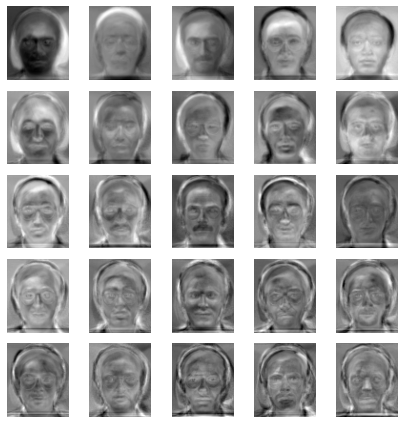

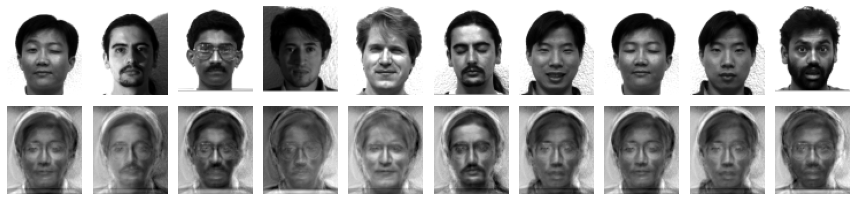

K=1: accuracy: 83.33% (25/30)
K=3: accuracy: 83.33% (25/30)
K=5: accuracy: 90.00% (27/30)
K=7: accuracy: 90.00% (27/30)
K=9: accuracy: 86.67% (26/30)
K=11: accuracy: 86.67% (26/30)
K=13: accuracy: 86.67% (26/30)
K=15: accuracy: 76.67% (23/30)
K=17: accuracy: 80.00% (24/30)
K=19: accuracy: 76.67% (23/30)


In [14]:
# PCA
W, _ = PCA(train_imgs)
PrintFace(W,'eigenface')
Reconstruct(W,train_imgs,'eigenface')
for k_neighbor in range(1,20,2):
    Prediction(W,train_imgs, train_labels, test_imgs, test_labels)

Class:: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.17it/s]


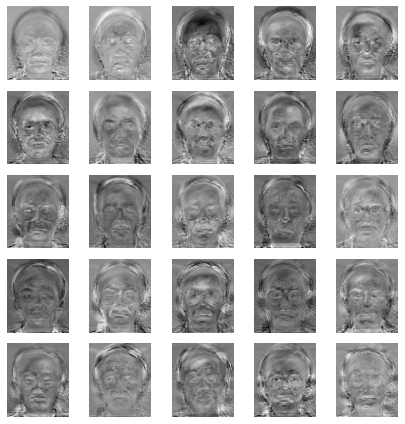

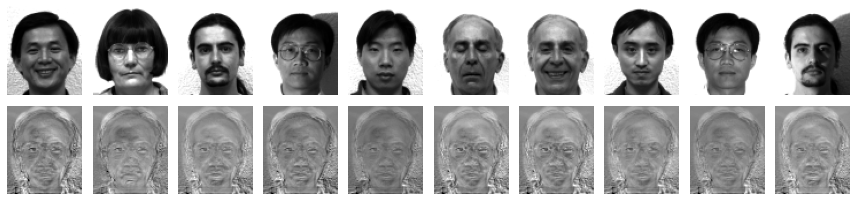

accuracy: 83.33% (25/30)
accuracy: 93.33% (28/30)
accuracy: 93.33% (28/30)
accuracy: 93.33% (28/30)
accuracy: 90.00% (27/30)
accuracy: 90.00% (27/30)
accuracy: 86.67% (26/30)
accuracy: 90.00% (27/30)
accuracy: 80.00% (24/30)
accuracy: 80.00% (24/30)


In [211]:
W, _ = LDA(train_imgs, train_labels)
PrintFace(W,'fisherface')
Reconstruct(W,train_imgs,'fisherface')
for k_neighbor in range(1,20,2):
    Prediction(W,train_imgs, train_labels, test_imgs, test_labels)

## Kernel PCA

In [133]:
mean = np.mean(train_imgs, axis = 0)
C_train = train_imgs - mean
C_test = test_imgs - mean

In [16]:
kernel = 'linear'
mean = np.mean(train_imgs, axis = 0)
C_train = train_imgs - mean
C_test = test_imgs - mean
W, train_K = PCA(C_train, kernel)
Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K=1: accuracy: 80.00% (24/30)
K=3: accuracy: 83.33% (25/30)
K=5: accuracy: 83.33% (25/30)
K=7: accuracy: 83.33% (25/30)
K=9: accuracy: 83.33% (25/30)
K=11: accuracy: 86.67% (26/30)
K=13: accuracy: 80.00% (24/30)
K=15: accuracy: 76.67% (23/30)
K=17: accuracy: 70.00% (21/30)
K=19: accuracy: 76.67% (23/30)


In [21]:
kernel = 'rbf'
gamma = 1e-6
W, train_K = PCA(C_train, kernel)
Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K=1: accuracy: 40.00% (12/30)
K=3: accuracy: 40.00% (12/30)
K=5: accuracy: 40.00% (12/30)
K=7: accuracy: 36.67% (11/30)
K=9: accuracy: 33.33% (10/30)
K=11: accuracy: 40.00% (12/30)
K=13: accuracy: 26.67% (8/30)
K=15: accuracy: 33.33% (10/30)
K=17: accuracy: 33.33% (10/30)
K=19: accuracy: 40.00% (12/30)


In [25]:
kernel = 'rbf'
gamma = 1e-7
W, train_K = PCA(C_train, kernel)
Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K=1: accuracy: 80.00% (24/30)
K=3: accuracy: 80.00% (24/30)
K=5: accuracy: 76.67% (23/30)
K=7: accuracy: 76.67% (23/30)
K=9: accuracy: 80.00% (24/30)
K=11: accuracy: 76.67% (23/30)
K=13: accuracy: 80.00% (24/30)
K=15: accuracy: 76.67% (23/30)
K=17: accuracy: 73.33% (22/30)
K=19: accuracy: 73.33% (22/30)


In [26]:
kernel = 'rbf'
gamma = 1e-8
W, train_K = PCA(C_train, kernel)
Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K=1: accuracy: 83.33% (25/30)
K=3: accuracy: 80.00% (24/30)
K=5: accuracy: 76.67% (23/30)
K=7: accuracy: 80.00% (24/30)
K=9: accuracy: 76.67% (23/30)
K=11: accuracy: 76.67% (23/30)
K=13: accuracy: 76.67% (23/30)
K=15: accuracy: 73.33% (22/30)
K=17: accuracy: 66.67% (20/30)
K=19: accuracy: 70.00% (21/30)


In [20]:
kernel = 'rbf'
gamma = 1e-10
W, train_K = PCA(C_train, kernel)
Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K=1: accuracy: 83.33% (25/30)
K=3: accuracy: 83.33% (25/30)
K=5: accuracy: 80.00% (24/30)
K=7: accuracy: 76.67% (23/30)
K=9: accuracy: 76.67% (23/30)
K=11: accuracy: 76.67% (23/30)
K=13: accuracy: 76.67% (23/30)
K=15: accuracy: 73.33% (22/30)
K=17: accuracy: 66.67% (20/30)
K=19: accuracy: 73.33% (22/30)


## Kernel LDA

In [219]:
kernel ='linear'
W, train_K = LDA(C_train,train_labels, kernel)
for k_neighbor in range(1,20,2):
    Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K = 1, accuracy: 80.00% (24/30)
K = 3, accuracy: 80.00% (24/30)
K = 5, accuracy: 80.00% (24/30)
K = 7, accuracy: 76.67% (23/30)
K = 9, accuracy: 76.67% (23/30)
K = 11, accuracy: 76.67% (23/30)
K = 13, accuracy: 80.00% (24/30)
K = 15, accuracy: 80.00% (24/30)
K = 17, accuracy: 76.67% (23/30)
K = 19, accuracy: 73.33% (22/30)


In [220]:
kernel = 'rbf'
gamma = 1e-6
W, train_K = LDA(C_train,train_labels, kernel)
for k_neighbor in range(1,20,2):
    Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K = 1, accuracy: 33.33% (10/30)
K = 3, accuracy: 26.67% (8/30)
K = 5, accuracy: 23.33% (7/30)
K = 7, accuracy: 23.33% (7/30)
K = 9, accuracy: 20.00% (6/30)
K = 11, accuracy: 20.00% (6/30)
K = 13, accuracy: 16.67% (5/30)
K = 15, accuracy: 16.67% (5/30)
K = 17, accuracy: 16.67% (5/30)
K = 19, accuracy: 6.67% (2/30)


In [221]:
kernel = 'rbf'
gamma = 1e-7
W, train_K = LDA(C_train,train_labels, kernel)
for k_neighbor in range(1,20,2):
    Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K = 1, accuracy: 80.00% (24/30)
K = 3, accuracy: 80.00% (24/30)
K = 5, accuracy: 80.00% (24/30)
K = 7, accuracy: 80.00% (24/30)
K = 9, accuracy: 76.67% (23/30)
K = 11, accuracy: 76.67% (23/30)
K = 13, accuracy: 80.00% (24/30)
K = 15, accuracy: 76.67% (23/30)
K = 17, accuracy: 76.67% (23/30)
K = 19, accuracy: 73.33% (22/30)


In [222]:
kernel = 'rbf'
gamma = 1e-8
W, train_K = LDA(C_train,train_labels, kernel)
for k_neighbor in range(1,20,2):
    Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K = 1, accuracy: 80.00% (24/30)
K = 3, accuracy: 80.00% (24/30)
K = 5, accuracy: 80.00% (24/30)
K = 7, accuracy: 76.67% (23/30)
K = 9, accuracy: 70.00% (21/30)
K = 11, accuracy: 70.00% (21/30)
K = 13, accuracy: 70.00% (21/30)
K = 15, accuracy: 70.00% (21/30)
K = 17, accuracy: 70.00% (21/30)
K = 19, accuracy: 70.00% (21/30)


In [223]:
kernel = 'rbf'
gamma = 1e-10
W, train_K = LDA(C_train,train_labels, kernel)
for k_neighbor in range(1,20,2):
    Prediction(W,C_train, train_labels, C_test, test_labels, train_K, kernel)

K = 1, accuracy: 80.00% (24/30)
K = 3, accuracy: 80.00% (24/30)
K = 5, accuracy: 76.67% (23/30)
K = 7, accuracy: 76.67% (23/30)
K = 9, accuracy: 70.00% (21/30)
K = 11, accuracy: 73.33% (22/30)
K = 13, accuracy: 70.00% (21/30)
K = 15, accuracy: 66.67% (20/30)
K = 17, accuracy: 60.00% (18/30)
K = 19, accuracy: 66.67% (20/30)
